**Set environment**

In [1]:
import sys
sys.path.append('../')
from config_sing import *

You are on Duke Server: Singularity: Proj CombEffect
BASE DIRECTORY:     /mount/work
PATH OF SOURCE:     /mount/work/source
PATH OF EXECUTABLE: /mount/work/exe
PATH OF ANNOTATION: /mount/work/annotation
PATH OF PROJECT:    /mount/project
PATH OF RESULTS:    /mount/work/out/proj_combeffect



In [2]:
### import tools
import math
import random
import pickle
import sqlite3
import itertools as it
from functools import reduce
from collections import defaultdict
from sklearn.manifold import TSNE

### plotting
import matplotlib as mpl
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("seaborn-whitegrid")

### Set Samples
fun = np.core.defchararray.add
idx = np.arange(1,6).astype("str")

INPUT20X = reduce(fun, ["Input", idx,     "_20x"])
TFX_DMSO = reduce(fun, ["TFX",   idx[1:], "_DMSO"])
TFX_DEX  = reduce(fun, ["TFX",   idx[1:], "_Dex"])
SAMPLES  = np.concatenate([INPUT20X, TFX_DMSO, TFX_DEX])

### file path of database
fdiry = os.path.join(FD_RES, 'database')
fname = "fragment_chr17.db"
FPATH_DB = os.path.join(fdiry, fname)

## Helper function

In [3]:
### https://stackoverflow.com/questions/12581437/python-random-sample-with-a-generator-iterable-iterator
def iter_sample_fast(iterable, samplesize):
    
    ### init
    results = []
    iterator = iter(iterable)
    
    ### Fill in the first samplesize elements:
    try:
        for _ in range(samplesize):
            results.append(next(iterator))
    except StopIteration:
        ### return everything if samplesize > len(iterable)
        random.shuffle(results)
        return results
    
    ### continue iterating through the elements and update the list
    random.shuffle(results)  # Randomize their positions
    for i, v in enumerate(iterator, samplesize):
        r = random.randint(0, i)
        if r < samplesize:
            results[r] = v  # at a decreasing rate, replace random items
    return results

In [4]:
def get_frag(sample, fpath_db=FPATH_DB):
    ### set query
    query_out = f"""
        SELECT Cnt.fragment, Cnt.count, Cnt.sample
        FROM   Count Cnt
        WHERE  Cnt.sample = '{sample}'
        """
    
    ### query out fragments from the sample
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query)
        for row in rows:
            yield row

def get_frag2(sample, start, end, fpath_db=FPATH_DB):
    ### set query
    query_out = f"""
        SELECT Cnt.fragment, Cnt.count, Cnt.sample, Frg.pct_gc
        FROM   Count Cnt
        JOIN   Fragment Frg ON Frg.fragment = Cnt.fragment
        WHERE  Cnt.sample = '{sample}' AND 
               Frg.start >= '{start}'  AND
               Frg.start <= '{end}'
        """
    
    ### query out fragments from the sample
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query)
        for row in rows:
            yield row            

def get_pct(frags, fpath_db=FPATH_DB):
    """..."""
    ###
    txt = ', '.join('?' for _ in frags)
    query_out = f"""
        SELECT   Frg.fragment, Frg.pct_gc
        FROM     Fragment Frg
        WHERE    Frg.fragment IN ({txt})
        ORDER BY Frg.fragment
        """
    
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query, frags)
    return rows

def get_depth(frag):
    """..."""
    ###
    chrom, start, end = frag.split("_")
    mid = math.ceil((int(start) + int(end)) / 2)
    query_out = f"""
        SELECT Cov.sample, Cov.depth, Sam.treatment, Sam.size
        FROM   Coverage Cov
        JOIN   Sample Sam ON Cov.sample = Sam.sample
        WHERE  Cov.location = {mid};
        """
    ###
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        cursor.execute(query)
        rows   = cursor.fetchall()
    
    ###
    cnames = ["Sample", "Depth", "Trt", "Size"]
    dat = pd.DataFrame(rows, columns=cnames)
    dat = dat.assign(LogNorm_Depth=lambda x: np.log1p(x.Depth) - np.log(x.Size))
    res1 = pd.Series(dat["LogNorm_Depth"].values, index=dat["Sample"])
    
    ###
    dat = dat.groupby("Trt")["LogNorm_Depth"].mean()
    dat["TFX_DMSO_vs_Inp20x"] = dat["TFX_DMSO"] - dat["Input_20x"]
    dat["TFX_Dex_vs_Inp20x"]  = dat["TFX_Dex"]  - dat["Input_20x"]
    dat["TFX_Dex_vs_DMSO"]    = dat["TFX_Dex"]  - dat["TFX_DMSO"]
    res2 = dat
    
    return pd.concat([res1, res2], axis=0)

def get_annot(frag, fpath_db=FPATH_DB, verbose=False):
    ### set query
    query_out = f"""
        SELECT Mtf.motif, Mtf.score
        FROM Annotation Ant
        JOIN Motif      Mtf ON Ant.binding = Mtf.binding
        WHERE Ant.fragment = '{frag}'
        """
    
    ### query out motif bindings on the fragment
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query)
        
    ### summarize the motif scores
    dct = defaultdict(lambda: 0)
    for idx, row in enumerate(rows):
        ### parse info
        motif, score = row

        ### sum the scores with same motifs
        dct[motif] += score
        
    if verbose:
        print(f"Fragment: {frg}; # Bindings: {idx+1}; # Motifs: {len(dct)}")
            
    return dct

## get fragments from PER1 region

In [5]:
%%time
random.seed(123)
N = 500

start = 8148000
end   = 8160000

lst_frg = list()
for sam in SAMPLES:
    print(sam)
    
    ### random select fragments
    gen = get_frag2(sam, start, end)
    lst = iter_sample_fast(gen, N)
    #lst = list(it.islice(gen, N))
    lst = np.sort(lst, axis=0)
    lst_frg.append(lst)

Input1_20x
Input2_20x
Input3_20x
Input4_20x
Input5_20x
TFX2_DMSO
TFX3_DMSO
TFX4_DMSO
TFX5_DMSO
TFX2_Dex
TFX3_Dex
TFX4_Dex
TFX5_Dex
CPU times: user 38.4 s, sys: 17.2 s, total: 55.7 s
Wall time: 6min 56s


In [6]:
sam = SAMPLES[0]
start = 8148000
end   = 8160000
gen = get_frag2(sam, start, end)
lst = list(gen)
len(lst)

3029

In [37]:
start = 8148000
end   = 8149100
sam   = "Input1_20x"
query_out = f"""
    SELECT Cnt.fragment, Cnt.count, Cnt.sample, Frg.pct_gc
    FROM   Count Cnt
    JOIN   Fragment Frg ON Frg.fragment = Cnt.fragment
    WHERE  Cnt.sample = '{sam}'    AND 
           Frg.start >= '{start}'  AND
           Frg.start <= '{end}'
    """
fpath_db = FPATH_DB
### query out fragments from the sample
with sqlite3.connect(fpath_db) as conn:
    query  = query_out
    cursor = conn.cursor()
    rows   = cursor.execute(query)
lst = list(rows)
lst

[('chr17_8148018_8148882', 3, 'Input1_20x', 0.582176),
 ('chr17_8149018_8150117', 1, 'Input1_20x', 0.590537),
 ('chr17_8149019_8150117', 1, 'Input1_20x', 0.591075),
 ('chr17_8149062_8149904', 1, 'Input1_20x', 0.585511),
 ('chr17_8149062_8149905', 3, 'Input1_20x', 0.586002)]

In [33]:
query_out = f"""
    SELECT Cnt.fragment, Cnt.count, Cnt.sample
    FROM   Count Cnt
    WHERE  Cnt.fragment == 'chr17_8148005_8149015'
    """
fpath_db = FPATH_DB
### query out fragments from the sample
with sqlite3.connect(fpath_db) as conn:
    query  = query_out
    cursor = conn.cursor()
    rows   = cursor.execute(query)
lst = list(rows)
lst

[('chr17_8148005_8149015', 1, 'Input1_20x')]

In [38]:
query_out = f"""
    SELECT Frg.fragment, Frg.pct_gc
    FROM   Fragment Frg
    WHERE  Frg.fragment == 'chr17_8148005_8149015'
    """
fpath_db = FPATH_DB
### query out fragments from the sample
with sqlite3.connect(fpath_db) as conn:
    query  = query_out
    cursor = conn.cursor()
    rows   = cursor.execute(query)
lst = list(rows)
lst

[]

In [39]:
with sqlite3.connect(fpath_db) as conn:
    cursor = conn.cursor()
    query = "select count(*) from Fragment"
    cursor.execute(query)
    print(cursor.fetchall())

[(1425854,)]


In [16]:
for lst in lst_frg:
    print(len(lst))

289
270
280
315
260
96
73
59
93
356
259
346
500


In [15]:
dat = pd.DataFrame(np.concatenate(lst_frg), columns=["Fragment", "Count", "Sample", "Pct_GC"])
dat.shape

(3196, 4)

In [11]:
dat = pd.DataFrame(np.concatenate(lst_frg), columns=["Fragment", "Count", "Sample", "Pct_GC"])
dat[['Chrom', 'Start', 'End']] = dat['Fragment'].str.split('_', expand=True)

dat = dat.astype({"Start": int, "End": int, "Count": int})
dat = dat.assign(Mid = lambda x: np.ceil((x.Start + x.End) / 2))
dat = dat.assign(Len = lambda x: x.End - x.Start)
dat = dat.astype({"Mid": int})

dat = dat.set_index("Fragment")
dat_frg_per1 = dat
dat_frg_per1

,Count,Sample,Pct_GC,Chrom,Start,End,Mid,Len
Fragment,,,,,,,,
chr17_8148018_8148882,1,Input1_20x,0.483249,chr17,8148018,8148882,8148450,864
chr17_8149018_8150117,1,Input1_20x,0.483773,chr17,8149018,8150117,8149568,1099
chr17_8149019_8150117,1,Input1_20x,0.518558,chr17,8149019,8150117,8149568,1098
chr17_8149062_8149904,1,Input1_20x,0.521018,chr17,8149062,8149904,8149483,842
chr17_8149062_8149905,1,Input1_20x,0.524785,chr17,8149062,8149905,8149484,843
...,...,...,...,...,...,...,...,...
chr17_8158126_8159014,8,TFX5_Dex,0.641164,chr17,8158126,8159014,8158570,888
chr17_8158167_8159110,8,TFX5_Dex,0.641469,chr17,8158167,8159110,8158639,943
chr17_8158177_8159104,8,TFX5_Dex,0.641684,chr17,8158177,8159104,8158641,927


In [13]:
dat_frg_per1.shape

(3196, 8)

In [12]:
frags = dat.index.to_numpy()
frags = np.unique(frags)
frags.shape

(1172,)

## GC content

In [16]:
%%time
gen = get_pct(frags)
dat_pct = pd.DataFrame(gen, columns = ["Fragment", "Pct_GC"])
dat_pct = dat_pct.set_index("Fragment")
dat_pct

CPU times: user 30.9 ms, sys: 28.1 ms, total: 59 ms
Wall time: 5.51 s


,Pct_GC
Fragment,
chr17_152554_153491,0.563501
chr17_201123_201923,0.586250
chr17_201123_201924,0.585518
chr17_201123_201925,0.584788
chr17_201337_202096,0.592885
...,...
chr17_441119_441996,0.573546
chr17_441119_441997,0.574032
chr17_441120_441997,0.574686


## Depth

In [19]:
%%time
dct = dict()
for frg in frags:
    dct[frg] = get_depth(frg)
    
dat_cov_full = pd.DataFrame.from_dict(dct, orient="index")
dat_cov_full.index.name = 'Fragment'
dat_cov_full

CPU times: user 45.5 s, sys: 3.19 s, total: 48.7 s
Wall time: 51.8 s


,Input1,Input2,Input3,Input4,Input5,Input1_20x,Input2_20x,Input3_20x,Input4_20x,Input5_20x,...,TFX3_Dex,TFX4_Dex,TFX5_Dex,Input,Input_20x,TFX_DMSO,TFX_Dex,TFX_DMSO_vs_Inp20x,TFX_Dex_vs_Inp20x,TFX_Dex_vs_DMSO
Fragment,,,,,,,,,,,,,,,,,,,,,
chr17_101601_102522,-16.742248,-16.819604,-16.963148,-16.760157,-16.544997,-19.733648,-19.666666,-19.673427,-19.840188,-19.647717,...,-17.088900,-17.359078,-17.560540,-16.766031,-19.712329,-17.108382,-17.409960,2.603947,2.302369,-0.301578
chr17_107410_108464,-16.742248,-16.819604,-16.963148,-16.760157,-16.544997,-19.040500,-19.666666,-19.673427,-19.840188,-19.647717,...,-17.088900,-17.359078,-17.560540,-16.766031,-19.573700,-17.281669,-17.409960,2.292031,2.163740,-0.128291
chr17_120738_123102,-16.742248,-16.819604,-16.963148,-16.760157,-16.544997,-19.733648,-19.666666,-19.673427,-19.840188,-18.954570,...,-16.395753,-17.359078,-17.560540,-16.766031,-19.573700,-17.281669,-17.236673,2.292031,2.337027,0.044996
chr17_120797_122228,-16.742248,-16.819604,-16.963148,-16.760157,-16.544997,-19.733648,-19.666666,-19.673427,-19.840188,-18.954570,...,-16.395753,-17.359078,-17.560540,-16.766031,-19.573700,-17.281669,-17.236673,2.292031,2.337027,0.044996
chr17_152554_153491,-16.742248,-16.819604,-16.963148,-16.760157,-16.544997,-19.733648,-19.666666,-19.673427,-19.147041,-18.954570,...,-17.088900,-17.359078,-16.867393,-16.766031,-19.435070,-17.281669,-17.063386,2.153401,2.371684,0.218283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr17_442890_443783,-13.797809,-13.684110,-13.967415,-14.052107,-13.836947,-13.847543,-13.831855,-13.877369,-13.921294,-13.756073,...,-12.826220,-13.407834,-13.977021,-13.867678,-13.846827,-13.459164,-13.487644,0.387663,0.359183,-0.028480
chr17_70104_71559,-16.742248,-16.819604,-16.963148,-16.760157,-16.544997,-19.733648,-19.666666,-19.673427,-19.840188,-19.647717,...,-17.088900,-17.359078,-16.867393,-16.766031,-19.712329,-17.281669,-17.236673,2.430660,2.475656,0.044996
chr17_83638_84547,-16.742248,-16.819604,-16.963148,-16.760157,-16.544997,-19.733648,-19.666666,-19.673427,-19.840188,-19.647717,...,-17.088900,-17.359078,-17.560540,-16.766031,-19.712329,-17.281669,-17.236673,2.430660,2.475656,0.044996


In [21]:
dat_cov = dat_cov_full.loc[:,["Input_20x", "TFX_DMSO_vs_Inp20x", "TFX_Dex_vs_Inp20x", "TFX_Dex_vs_DMSO"]]
dat_cov

,Input_20x,TFX_DMSO_vs_Inp20x,TFX_Dex_vs_Inp20x,TFX_Dex_vs_DMSO
Fragment,,,,
chr17_101601_102522,-19.712329,2.603947,2.302369,-0.301578
chr17_107410_108464,-19.573700,2.292031,2.163740,-0.128291
chr17_120738_123102,-19.573700,2.292031,2.337027,0.044996
chr17_120797_122228,-19.573700,2.292031,2.337027,0.044996
chr17_152554_153491,-19.435070,2.153401,2.371684,0.218283
...,...,...,...,...
chr17_442890_443783,-13.846827,0.387663,0.359183,-0.028480
chr17_70104_71559,-19.712329,2.430660,2.475656,0.044996
chr17_83638_84547,-19.712329,2.430660,2.475656,0.044996


## Annotation

In [14]:
%%time
dct = dict()
for frg in frags:
    dct[frg] = get_annot(frg)
    
dat_ant = pd.DataFrame.from_dict(dct, orient="index").fillna(0)
dat_ant = dat_ant.add_prefix("Mtf_")
dat_ant.index.name = 'Fragment'
dat_ant

CPU times: user 6.55 s, sys: 4.04 s, total: 10.6 s
Wall time: 2min 19s


,Mtf_SREBF1,Mtf_ZBTB48,Mtf_MEF2,Mtf_ZNF250,Mtf_Ebox/CAGATGG,Mtf_ZSCAN3,Mtf_KLF/SP/2,Mtf_GC-tract,Mtf_GCM,Mtf_OSR2,...,Mtf_HSFY2,Mtf_HD/1,Mtf_HD/8,Mtf_MYB/1,Mtf_CUX/2,Mtf_GMEB2/1,Mtf_ZNF435,Mtf_HD/13,Mtf_HD/24,Mtf_HD/3
Fragment,,,,,,,,,,,,,,,,,,,,,
chr17_101601_102522,27.1003,8.0202,8.5217,4.4231,7.869500,18.8976,47.535633,58.819195,8.86135,26.6573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_107410_108464,7.5326,0.0000,17.2987,1.0741,16.579600,8.7410,48.251250,88.081300,7.32000,17.7580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_152554_153491,18.6540,0.0000,0.0000,0.0000,72.649633,8.9986,56.985300,63.676050,0.00000,19.1826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_152590_153715,38.2407,0.0000,8.7770,0.0000,72.649633,17.2574,67.497000,82.447550,0.00000,27.3613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_152749_153715,38.2407,0.0000,8.7770,0.0000,65.002433,17.2574,57.998400,70.686000,0.00000,17.0657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr17_249656_250585,0.0000,0.0000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_249662_250695,0.0000,0.0000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_249663_250695,0.0000,0.0000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Merge all information

In [22]:
dat = dat_frg.join(dat_pct).join(dat_cov).join(dat_ant)
dat = dat.reset_index()

dat["Sample"] = pd.Categorical(dat["Sample"], SAMPLES)
dat = dat.sort_values(["Sample", "Fragment"])
dat

,Fragment,Count,Sample,Chrom,Start,End,Mid,Len,Pct_GC,Input_20x,...,Mtf_HSFY2,Mtf_HD/1,Mtf_HD/8,Mtf_MYB/1,Mtf_CUX/2,Mtf_GMEB2/1,Mtf_ZNF435,Mtf_HD/13,Mtf_HD/24,Mtf_HD/3
1,chr17_107410_108464,1,Input1_20x,chr17,107410,108464,107937,1054,NaN,-19.573700,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0
13,chr17_159026_160040,1,Input1_20x,chr17,159026,160040,159533,1014,NaN,-18.579737,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0
19,chr17_159426_160303,1,Input1_20x,chr17,159426,160303,159865,877,NaN,-18.579737,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0
21,chr17_159510_160362,1,Input1_20x,chr17,159510,160362,159936,852,NaN,-18.579737,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0
28,chr17_159977_160849,1,Input1_20x,chr17,159977,160849,160413,872,NaN,-19.157811,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6081,chr17_418856_419822,4,TFX5_Dex,chr17,418856,419822,419339,966,0.494824,-14.376964,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,6.9155,0.0,0.0
6102,chr17_419204_420122,4,TFX5_Dex,chr17,419204,420122,419663,918,0.480392,-14.270837,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,6.9155,0.0,0.0
6105,chr17_419271_420253,5,TFX5_Dex,chr17,419271,420253,419762,982,0.494908,-14.363426,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0
6108,chr17_419271_420254,6,TFX5_Dex,chr17,419271,420254,419763,983,0.494405,-14.363426,...,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0


## Dimention Reduction

In [25]:
%%time
lst = [col for col in dat.columns if col.startswith('Mtf')]
X   = dat[lst].to_numpy()
X = TSNE(n_components=2, init='pca', random_state=123).fit_transform(X)

dat = dat.assign(tsne_x = X[:,0], tsne_y = X[:,1])
dat

CPU times: user 1min 30s, sys: 237 ms, total: 1min 31s
Wall time: 54.7 s


,Fragment,Count,Sample,Chrom,Start,End,Mid,Len,Pct_GC,Input_20x,...,Mtf_HD/8,Mtf_MYB/1,Mtf_CUX/2,Mtf_GMEB2/1,Mtf_ZNF435,Mtf_HD/13,Mtf_HD/24,Mtf_HD/3,tsne_x,tsne_y
1,chr17_107410_108464,1,Input1_20x,chr17,107410,108464,107937,1054,NaN,-19.573700,...,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,1.902652,-43.462234
13,chr17_159026_160040,1,Input1_20x,chr17,159026,160040,159533,1014,NaN,-18.579737,...,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,-61.625534,25.076084
19,chr17_159426_160303,1,Input1_20x,chr17,159426,160303,159865,877,NaN,-18.579737,...,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,-61.119606,23.775232
21,chr17_159510_160362,1,Input1_20x,chr17,159510,160362,159936,852,NaN,-18.579737,...,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,-60.957027,23.292553
28,chr17_159977_160849,1,Input1_20x,chr17,159977,160849,160413,872,NaN,-19.157811,...,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,31.880983,36.765915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6081,chr17_418856_419822,4,TFX5_Dex,chr17,418856,419822,419339,966,0.494824,-14.376964,...,0.0000,0.0,0.0,0.0000,0.0,6.9155,0.0,0.0,-12.330408,-52.474735
6102,chr17_419204_420122,4,TFX5_Dex,chr17,419204,420122,419663,918,0.480392,-14.270837,...,0.0000,0.0,0.0,0.0000,0.0,6.9155,0.0,0.0,-17.179312,-49.599594
6105,chr17_419271_420253,5,TFX5_Dex,chr17,419271,420253,419762,982,0.494908,-14.363426,...,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,-17.071539,-48.079681
6108,chr17_419271_420254,6,TFX5_Dex,chr17,419271,420254,419763,983,0.494405,-14.363426,...,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,-17.073055,-48.079594


In [26]:
print(dat_frg.shape)
print(dat_pct.shape)
print(dat_ant.shape)
print(dat.shape)

(6500, 7)
(511, 1)
(5251, 272)
(6500, 287)


## Plot

In [27]:
def set_colorbar(fig, ax, im):
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:335: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


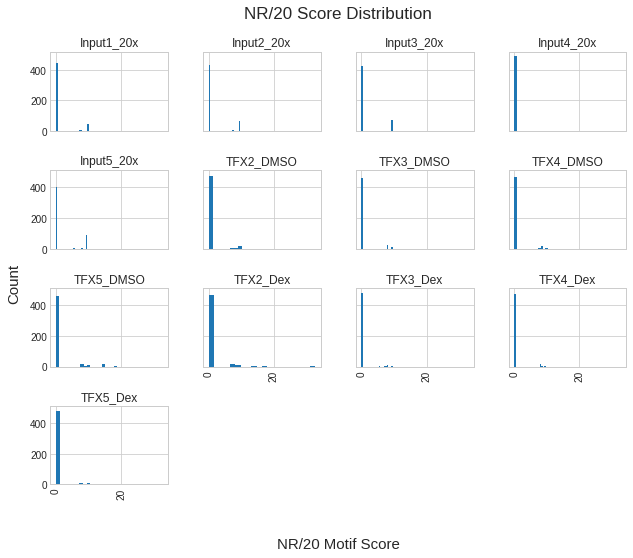

In [28]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
axes = dat.loc[:,"Mtf_NR/20"].hist(
    ax=ax,
    bins=20, 
    by=dat.loc[:,"Sample"], 
    #density=True, 
    sharex=True,
    sharey=True)

#axes = np.ravel(axes)
#for ax in axes:
#    ax.set_yscale('log')
    
fig.suptitle("NR/20 Score Distribution", fontsize=17)
fig.text(0.5, 0.04, 'NR/20 Motif Score', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', fontsize=15)
plt.show()

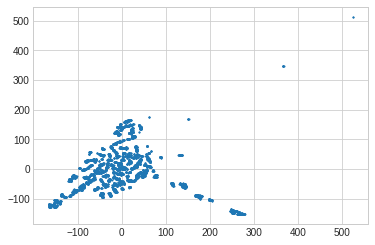

In [29]:
plt.scatter(dat["tsne_x"], dat["tsne_y"], s=1)

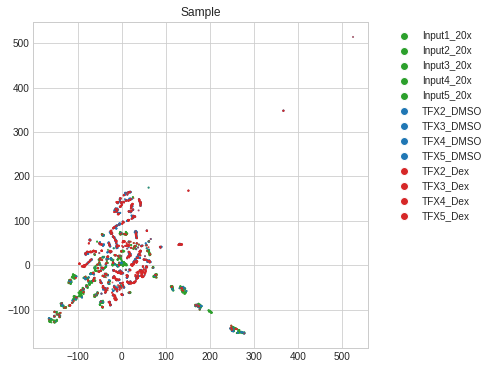

In [30]:
###
### Ref: stackoverflow: plot-different-color-for-different-categorical-levels-using-matplotlib 

### set color mapping
#colors = list(sns.color_palette("Greens", 5)) + list(sns.color_palette("Blues", 4)) + list(sns.color_palette("Reds", 4))
colors = ["tab:green"] * 5 + ["tab:blue"] * 4 + ["tab:red"] * 4
colors = {k:v for k, v in zip(SAMPLES, colors)}

### scatter plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(dat["tsne_x"], dat["tsne_y"], s=1, c=dat.loc[:,"Sample"].map(colors), alpha=0.5)


### add a legend
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) 
    for k, v in colors.items()
]
ax.legend(title='', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title("Sample")
plt.show()

## get fragments from larger region

In [40]:
%%time
random.seed(123)
N = 100000

lst_frg = list()
for sam in SAMPLES:
    print(sam)
    
    ### random select fragments
    gen = get_frag(sam)
    lst = iter_sample_fast(gen, N)
    #lst = list(it.islice(gen, N))
    lst = np.sort(lst, axis=0)
    lst_frg.append(lst)

Input1_20x
Input2_20x
Input3_20x
Input4_20x
Input5_20x
TFX2_DMSO
TFX3_DMSO
TFX4_DMSO
TFX5_DMSO
TFX2_Dex
TFX3_Dex
TFX4_Dex
TFX5_Dex
CPU times: user 2min 46s, sys: 4.54 s, total: 2min 51s
Wall time: 2min 56s


In [41]:
dat = pd.DataFrame(np.concatenate(lst_frg), columns=["Fragment", "Count", "Sample"])
dat[['Chrom', 'Start', 'End']] = dat['Fragment'].str.split('_', expand=True)

dat = dat.astype({"Start": int, "End": int, "Count": int})
dat = dat.assign(Mid = lambda x: np.ceil((x.Start + x.End) / 2))
dat = dat.assign(Len = lambda x: x.End - x.Start)
dat = dat.astype({"Mid": int})

dat = dat.set_index("Fragment")
dat_frg_chr17 = dat
dat_frg_chr17

,Count,Sample,Chrom,Start,End,Mid,Len
Fragment,,,,,,,
chr17_10000921_10001863,1,Input1_20x,chr17,10000921,10001863,10001392,942
chr17_10001144_10002163,1,Input1_20x,chr17,10001144,10002163,10001654,1019
chr17_10002319_10003263,1,Input1_20x,chr17,10002319,10003263,10002791,944
chr17_10003369_10004362,1,Input1_20x,chr17,10003369,10004362,10003866,993
chr17_10003841_10004805,1,Input1_20x,chr17,10003841,10004805,10004323,964
...,...,...,...,...,...,...,...
chr17_9998179_9999089,9,TFX5_Dex,chr17,9998179,9999089,9998634,910
chr17_9998180_9999089,9,TFX5_Dex,chr17,9998180,9999089,9998635,909
chr17_9998189_9999190,9,TFX5_Dex,chr17,9998189,9999190,9998690,1001


In [42]:
frags = dat.index.to_numpy()
frags = np.unique(frags)
frags.shape

(1281022,)

In [43]:
%%time
dct = dict()
for frg in frags:
    dct[frg] = get_annot(frg)
    
dat_ant = pd.DataFrame.from_dict(dct, orient="index").fillna(0)
dat_ant = dat_ant.add_prefix("Mtf_")
dat_ant.index.name = 'Fragment'
dat_ant

CPU times: user 26min, sys: 9min 13s, total: 35min 14s
Wall time: 6h 15min 12s


,Mtf_GATA,Mtf_Ebox/CAGATGG,Mtf_ZNF85,Mtf_Ebox/CAGCTG,Mtf_Ebox/CACCTG,Mtf_BATF,Mtf_CTCF,Mtf_EBF1,Mtf_SMAD,Mtf_HD/18,...,Mtf_HD/1,Mtf_MYB/3,Mtf_BCL6/1,Mtf_NR/6,Mtf_GMEB2/3,Mtf_CUX/3,Mtf_HD/3,Mtf_SOX/7,Mtf_ZBED1,Mtf_HINFP1/3
Fragment,,,,,,,,,,,,,,,,,,,,,
chr17_10000034_10001048,7.0149,31.6391,6.6182,28.2668,18.2044,25.4103,16.1923,8.3601,16.8618,13.8423,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_10000921_10001863,7.2490,18.0853,0.0000,27.7834,10.5620,0.0000,6.7009,9.8407,16.1334,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_10000934_10001922,7.2490,18.0853,0.0000,35.4359,10.5620,0.0000,6.7009,9.8407,16.1334,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_10000934_10001924,7.2490,18.0853,0.0000,35.4359,10.5620,0.0000,6.7009,9.8407,16.1334,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_10001023_10002055,7.2490,34.4490,0.0000,35.4359,18.7967,0.0000,6.7009,9.8407,23.6249,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr17_42337837_42338633,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_70277790_70278571,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,7.8882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr17_82259812_82260611,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
print(1)

1


In [46]:
dat_ant_chr17 = dat_ant

In [47]:
dat_frg = dat_frg_chr17
dat_ant = dat_ant_chr17

dat = dat_frg.join(dat_ant)
dat = dat.reset_index()

dat["Sample"] = pd.Categorical(dat["Sample"], SAMPLES)
dat = dat.sort_values(["Sample", "Fragment"])
dat

,Fragment,Count,Sample,Chrom,Start,End,Mid,Len,Mtf_GATA,Mtf_Ebox/CAGATGG,...,Mtf_HD/1,Mtf_MYB/3,Mtf_BCL6/1,Mtf_NR/6,Mtf_GMEB2/3,Mtf_CUX/3,Mtf_HD/3,Mtf_SOX/7,Mtf_ZBED1,Mtf_HINFP1/3
24,chr17_10000921_10001863,1,Input1_20x,chr17,10000921,10001863,10001392,942,7.2490,18.0853,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
30,chr17_10001144_10002163,1,Input1_20x,chr17,10001144,10002163,10001654,1019,7.2490,34.4490,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
40,chr17_10002319_10003263,1,Input1_20x,chr17,10002319,10003263,10002791,944,12.4162,7.0212,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
86,chr17_10003369_10004362,1,Input1_20x,chr17,10003369,10004362,10003866,993,0.0000,20.1556,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
100,chr17_10003841_10004805,1,Input1_20x,chr17,10003841,10004805,10004323,964,0.0000,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299955,chr17_9998179_9999089,9,TFX5_Dex,chr17,9998179,9999089,9998634,910,7.3341,0.0000,...,0.0,0.0,0.0,7.4513,0.0,0.0,0.0,0.0000,0.0,0.0
1299956,chr17_9998180_9999089,9,TFX5_Dex,chr17,9998180,9999089,9998635,909,7.3341,0.0000,...,0.0,0.0,0.0,7.4513,0.0,0.0,0.0,0.0000,0.0,0.0
1299957,chr17_9998189_9999190,9,TFX5_Dex,chr17,9998189,9999190,9998690,1001,7.3341,7.4244,...,0.0,0.0,0.0,7.4513,0.0,0.0,0.0,0.0000,0.0,0.0
1299981,chr17_9998666_9999755,9,TFX5_Dex,chr17,9998666,9999755,9999211,1089,17.7570,18.0052,...,0.0,0.0,0.0,7.4513,0.0,0.0,0.0,6.9509,0.0,0.0


In [51]:
fdiry = os.path.join(FD_RES, "database")
fname = "fragment_annotation_chr17.P"
fpath = os.path.join(fdiry, fname)

print(fpath)
with open(fpath, 'wb') as file:
    dct = dict()
    dct["fragment"]   = dat_frg_chr17
    dct["annotation"] = dat_ant_chr17
    pickle.dump(dct, file)
print("Done!")

/mount/work/out/proj_combeffect/database/fragment_annotation_chr17.P
Done!


## load from pickle file

In [5]:
fdiry = os.path.join(FD_RES, "database")
fname = "fragment_annotation_chr17.P"
fpath = os.path.join(fdiry, fname)

print(fpath)
with open(fpath, 'rb') as file:
    dct = pickle.load(file)
print("Done!")

/mount/work/out/proj_combeffect/database/fragment_annotation_chr17.P
Done!


In [6]:
dct.keys()

dict_keys(['fragment', 'annotation'])

In [7]:
dat_frg = dct["fragment"]  
dat_ant = dct["annotation"]

dat = dat_frg.join(dat_ant)
dat = dat.reset_index()

dat["Sample"] = pd.Categorical(dat["Sample"], SAMPLES)
dat = dat.sort_values(["Sample", "Fragment"])
dat

,Fragment,Count,Sample,Chrom,Start,End,Mid,Len,Mtf_GATA,Mtf_Ebox/CAGATGG,...,Mtf_HD/1,Mtf_MYB/3,Mtf_BCL6/1,Mtf_NR/6,Mtf_GMEB2/3,Mtf_CUX/3,Mtf_HD/3,Mtf_SOX/7,Mtf_ZBED1,Mtf_HINFP1/3
24,chr17_10000921_10001863,1,Input1_20x,chr17,10000921,10001863,10001392,942,7.2490,18.0853,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
30,chr17_10001144_10002163,1,Input1_20x,chr17,10001144,10002163,10001654,1019,7.2490,34.4490,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
40,chr17_10002319_10003263,1,Input1_20x,chr17,10002319,10003263,10002791,944,12.4162,7.0212,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
86,chr17_10003369_10004362,1,Input1_20x,chr17,10003369,10004362,10003866,993,0.0000,20.1556,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
100,chr17_10003841_10004805,1,Input1_20x,chr17,10003841,10004805,10004323,964,0.0000,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299955,chr17_9998179_9999089,9,TFX5_Dex,chr17,9998179,9999089,9998634,910,7.3341,0.0000,...,0.0,0.0,0.0,7.4513,0.0,0.0,0.0,0.0000,0.0,0.0
1299956,chr17_9998180_9999089,9,TFX5_Dex,chr17,9998180,9999089,9998635,909,7.3341,0.0000,...,0.0,0.0,0.0,7.4513,0.0,0.0,0.0,0.0000,0.0,0.0
1299957,chr17_9998189_9999190,9,TFX5_Dex,chr17,9998189,9999190,9998690,1001,7.3341,7.4244,...,0.0,0.0,0.0,7.4513,0.0,0.0,0.0,0.0000,0.0,0.0
1299981,chr17_9998666_9999755,9,TFX5_Dex,chr17,9998666,9999755,9999211,1089,17.7570,18.0052,...,0.0,0.0,0.0,7.4513,0.0,0.0,0.0,6.9509,0.0,0.0


In [ ]:
%%time
lst = [col for col in dat.columns if col.startswith('Mtf')]
X   = dat[lst].to_numpy()
X = TSNE(n_components=2, init='pca', random_state=123).fit_transform(X)

dat = dat.assign(tsne_x = X[:,0], tsne_y = X[:,1])
dat

In [ ]:
fdiry = os.path.join(FD_RES, "database")
fname = "fragment_annotation_chr17.P"
fpath = os.path.join(fdiry, fname)

print(fpath)
with open(fpath, 'wb') as file:
    dct = dict()
    dct["fragment"]   = dat_frg_chr17
    dct["annotation"] = dat_ant_chr17
    dct["tsne"]       = X
    pickle.dump(dct, file)
print("Done!")